In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.nn.functional as F
import lzma
import numpy as np
import matplotlib.pyplot as plt
import random
import json
import pickle
from torch.utils.data import TensorDataset, DataLoader
import itertools
import os

In [2]:
from utils.model import deviceof, set_lr_on_step
from utils.env import State, Action, Observation, Transition, state_batch_to_tensor, action_batch_to_tensor, obs_batch_to_tensor
from utils.idm_model_def import InverseDynamicsModel, idm_train_direct_batch
from utils.loader import getFiles
from utils.waymo_loader import extract_scenarios_file

2023-09-17 10:55:54.959006: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-17 10:55:56.243823: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
# CHANGE ME: Set this to the path to the Waymo Open Dataset root directory
WAYMO_DATA_PATH = "~/data/waymo"

In [4]:
# load data
with lzma.open("./data/transition_data.pkl.xz", "rb") as f:
    transition_data: list[Transition] = pickle.load(f)

# 90:10 train-validation split
transition_train_data = transition_data[:int(len(transition_data)*0.5)]
transition_validation_data = transition_data[int(len(transition_data)*0.5):]

print("train data size:", len(transition_train_data))
print("validation data size:", len(transition_validation_data))

train data size: 450000
validation data size: 50000


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [25]:
idm_train_dataset = TensorDataset(
    obs_batch_to_tensor([Observation(t.state, t.next_state) for t in transition_train_data], torch.device("cpu")),
    action_batch_to_tensor([t.action for t in transition_train_data], torch.device("cpu")),
)
idm_train_loader = DataLoader(idm_train_dataset, batch_size=8192)
idm_train_iter = itertools.cycle(iter(idm_train_loader))

idm = InverseDynamicsModel().to(device)

idm_optimizer = torch.optim.AdamW(idm.parameters(), lr=0.0)

idm_step = 0
idm_losses = []

In [40]:
LR_SCHEDULE = {
    0: 1e-3,
    15_000: 5e-4,
    20_000: 2e-4,
    30_000: 1e-4,
    30_000: 5e-5,
    45_000: 2e-5,
    50_000: 1e-5,
}
INVERSE_DYNAMICS_MODEL_TRAIN_EPOCHS = 55_000
idm.train()
while idm_step < INVERSE_DYNAMICS_MODEL_TRAIN_EPOCHS:
    set_lr_on_step(idm_step, idm_optimizer, LR_SCHEDULE)
    obs_tensor, a_tensor = next(idm_train_iter) 
    loss = idm_train_direct_batch(
        idm,
        idm_optimizer,
        obs_tensor,
        a_tensor,
    )
    idm_losses.append(loss)
    idm_step += 1
    if idm_step % 1000 == 0:
        # print average loss over last 100 steps
        loss = np.mean(idm_losses[-1000:])
        print(f"Step: {idm_step}, Loss: {loss:.6f}")

Step: 24000, Loss: 0.027550
Step: 25000, Loss: 0.027434
Step: 26000, Loss: 0.027314
Step: 27000, Loss: 0.027179
Step: 28000, Loss: 0.027101
Step: 29000, Loss: 0.026976
Step: 30000, Loss: 0.026803
Set learning rate to 5e-05 on step 30000
Step: 31000, Loss: 0.025825
Step: 32000, Loss: 0.025676
Step: 33000, Loss: 0.025568
Step: 34000, Loss: 0.025461
Step: 35000, Loss: 0.025423
Step: 36000, Loss: 0.025352
Step: 37000, Loss: 0.025279
Step: 38000, Loss: 0.025213
Step: 39000, Loss: 0.025154
Step: 40000, Loss: 0.025103
Step: 41000, Loss: 0.025067


KeyboardInterrupt: 

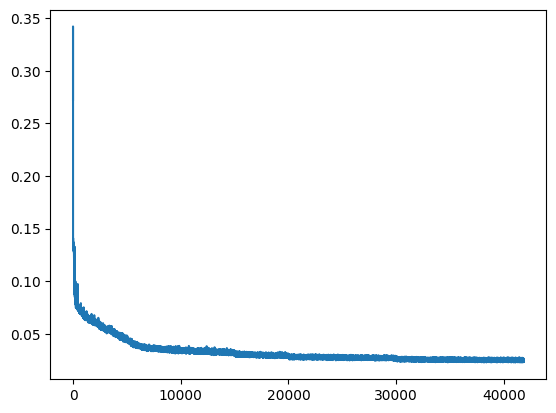

In [41]:
import matplotlib.pyplot as plt

# Plot the losses over training
plt.plot(list(range(len(idm_losses))), idm_losses, label='IDM')
plt.show()

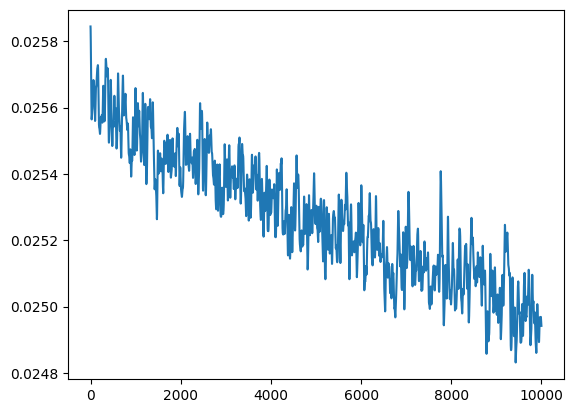

In [42]:
from scipy.ndimage import gaussian_filter1d

# plot the average reward per episode
idm_losses_averaged = gaussian_filter1d(idm_losses[-10000:], sigma=10)
plt.plot(idm_losses_averaged)

In [34]:
# save IDM
if not os.path.exists('./data/idm.pth'):
    torch.save(idm.state_dict(), './data/idm.pth')

: 

In [23]:
# load IDM
if 'idm' not in locals():
    idm = InverseDynamicsModel().to(device)
    idm.load_state_dict(torch.load('./data/idm.pth'))

In [39]:
idm.eval()

obs_tensor = obs_batch_to_tensor([Observation(t.state, t.next_state) for t in transition_train_data], device)
a_tensor = action_batch_to_tensor([t.action for t in transition_train_data], device)


a_pred_tensor = idm(obs_tensor)

loss = (a_tensor - a_pred_tensor)**2
loss_steer = loss[:, 0].cpu().detach().numpy()
loss_throttle = loss[:, 1].cpu().detach().numpy()

print("training loss", loss.mean().item())

training loss 0.03399418294429779


In [43]:
idm.eval()

obs_tensor = obs_batch_to_tensor([Observation(t.state, t.next_state) for t in transition_validation_data], device)
a_tensor = action_batch_to_tensor([t.action for t in transition_validation_data], device)

with torch.no_grad():
    a_pred_tensor = idm(obs_tensor)

loss = (a_tensor - a_pred_tensor)**2
loss_steer = loss[:, 0].cpu().detach().numpy()
loss_throttle = loss[:, 1].cpu().detach().numpy()

print("validation loss", loss.mean().item())

validation loss 0.031374841928482056


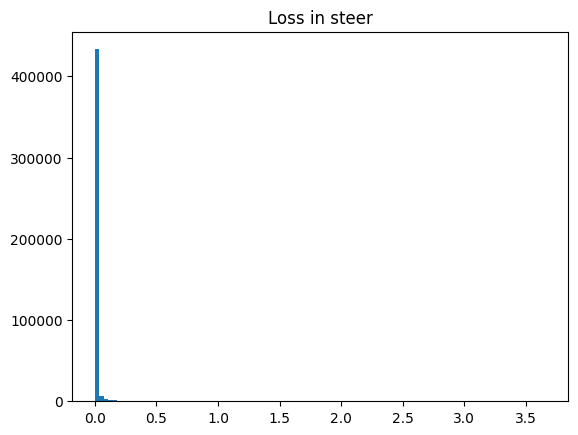

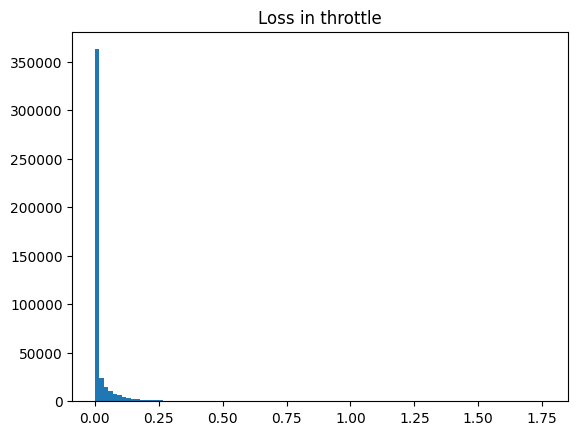

In [37]:
plt.hist(loss_steer, bins=100)
plt.title('Loss in steer')
plt.show()
plt.hist(loss_throttle, bins=100)
plt.title('Loss in throttle')
plt.show()

In [13]:
class IDMPolicy:
    def __init__(self, net: InverseDynamicsModel):
        self.net = net

    def __call__(self, obs:Observation) -> Action:
        # sample an action from the policy network
        obs_tensor = obs_batch_to_tensor([obs], deviceof(self.net))
        # sample an action from the policy network
        with torch.no_grad():
            steering, throttle = self.net(obs_tensor)[0]
        return Action(steering.item(), throttle.item())

In [14]:
scenarios = extract_scenarios_file(getFiles(WAYMO_DATA_PATH)[0])

2023-09-16 21:26:25.732171: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-16 21:26:25.748789: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-16 21:26:25.748991: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [20]:
# load waymo trained IDM for reference
waymo_idm = InverseDynamicsModel().to(device)
waymo_idm.load_state_dict(torch.load('./data/waymo/idm.pth'))

<All keys matched successfully>

In [28]:
obs_tensor = obs_batch_to_tensor([Observation(t.state, t.next_state) for t in transition_validation_data], device)
a_tensor = action_batch_to_tensor([t.action for t in transition_validation_data], device)

with torch.no_grad():
    a_pred_tensor = waymo_idm(obs_tensor)

loss = (a_tensor - a_pred_tensor)**2
loss_steer = loss[:, 0].cpu().detach().numpy()
loss_throttle = loss[:, 1].cpu().detach().numpy()

print("validation loss", loss.mean().item())

validation loss 0.33466291427612305


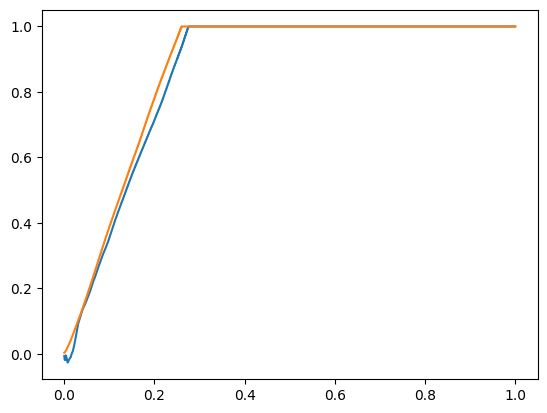

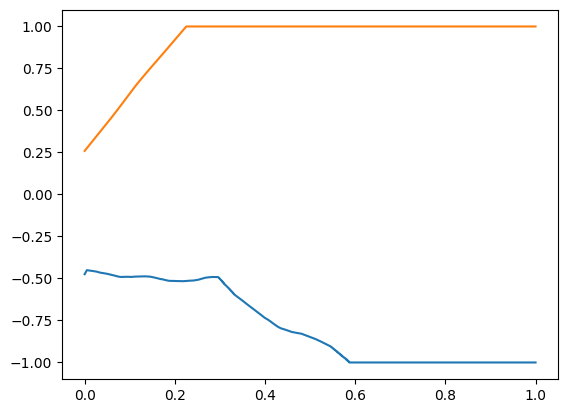

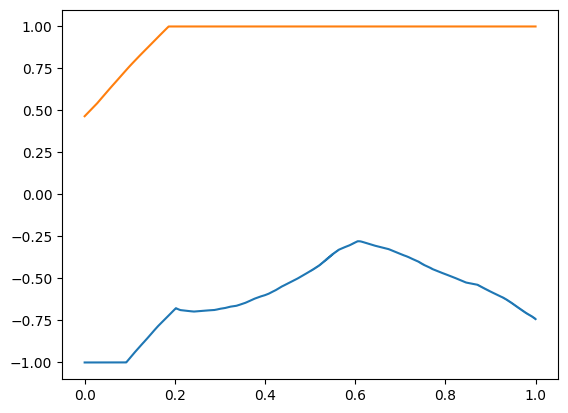

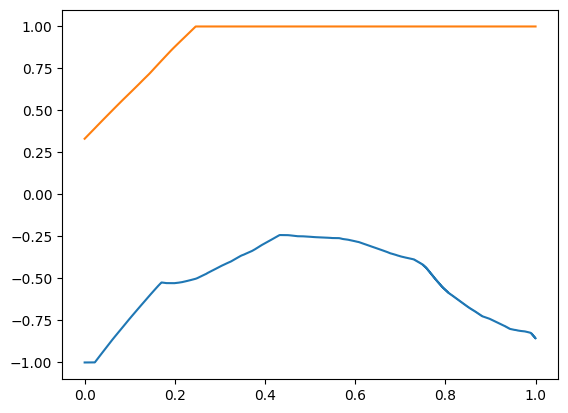

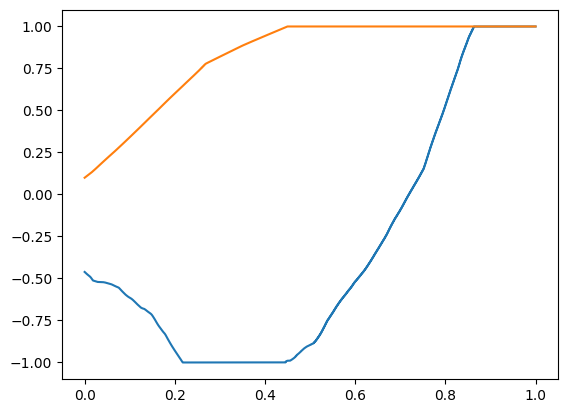

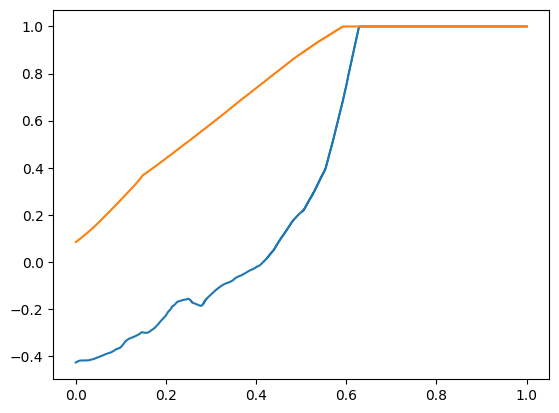

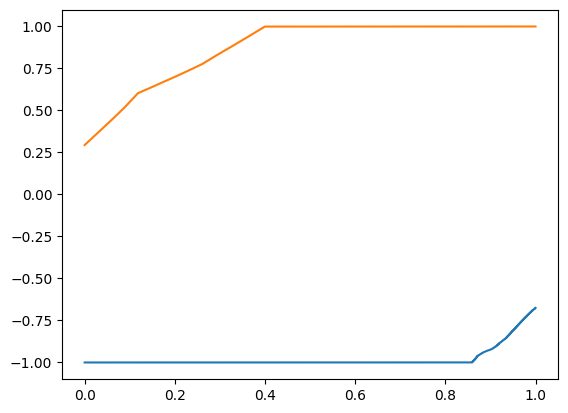

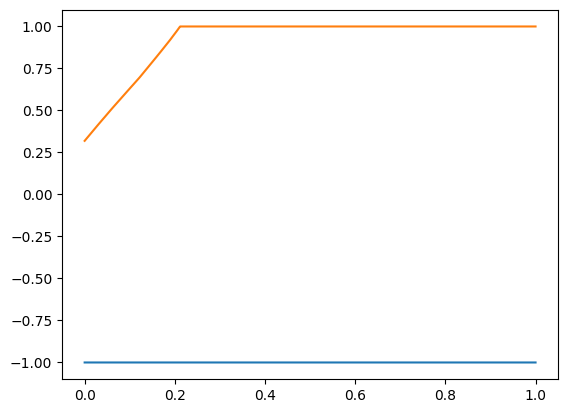

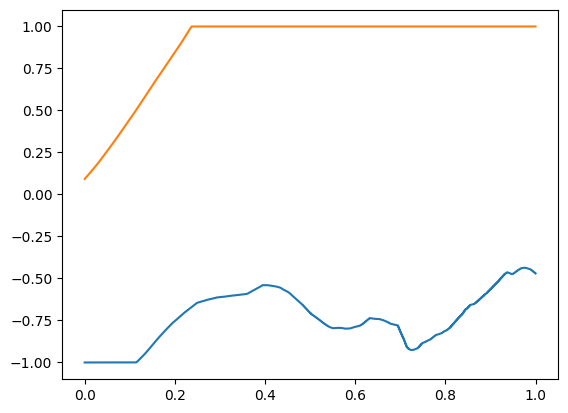

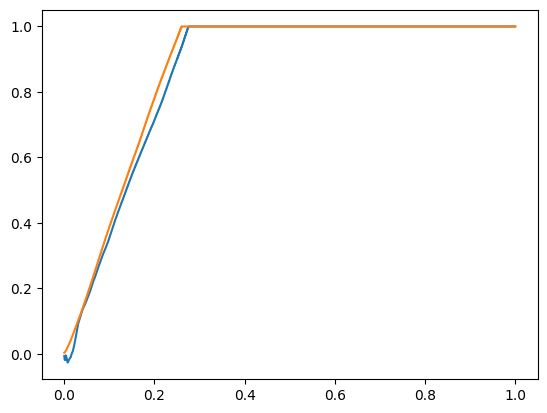

In [29]:
vels = np.linspace([0, 0], [1, 0], 10000)


for h in np.linspace(0, 2*np.pi, 10):
    headings = np.linspace(0, 0, 10000) + h

    obs_batch = obs_batch_to_tensor([Observation(State(0, (0, 0)), State(heading, (x, y))) for (x,y), heading in zip(vels, headings)], device)
    action_batch = idm(obs_batch)
    waymo_action_batch = waymo_idm(obs_batch)

    plt.plot(vels[:, 0], action_batch[:, 1].cpu().detach().numpy(), label='throttle')
    plt.plot(vels[:, 0], waymo_action_batch[:, 1].cpu().detach().numpy(), label='waymo throttle')
    plt.show()

In [19]:
s0data:list[Transition] = []

for transition in transition_data:
    v0 = np.array(transition.state.velocity)
    h0 = transition.state.heading
    if np.linalg.norm(v0) < 0.01 and np.abs(h0) < 0.1:
        s0data.append(transition)

In [20]:
len(s0data)

78

In [21]:
s0data

[Transition(state=State(heading=0.09573662565001495, velocity=(-0.00038109630762428936, -0.003361144370495221)), action=Action(steer=-0.3999467893738744, throttle=-0.02113682018870415), next_state=State(heading=0.09573984224002174, velocity=array([-0.00366888, -0.00036283]))),
 Transition(state=State(heading=0.08766928982610489, velocity=(-0.00981782628818165, -0.001368423083238782)), action=Action(steer=-0.9630351734406006, throttle=0.0871087571959927), next_state=State(heading=0.08760588248064671, velocity=array([ 0.01331215, -0.00459047]))),
 Transition(state=State(heading=0.016739017047668003, velocity=(3.980600289220679e-05, 0.0004274124830181357)), action=Action(steer=0.15463227477256325, throttle=0.06583375918024109), next_state=State(heading=0.016754212733797402, velocity=array([0.01815705, 0.00143424]))),
 Transition(state=State(heading=0.060887420932898006, velocity=(0.003668110188998446, 0.005105324141580293)), action=Action(steer=0.7299211418276939, throttle=0.1015650873731

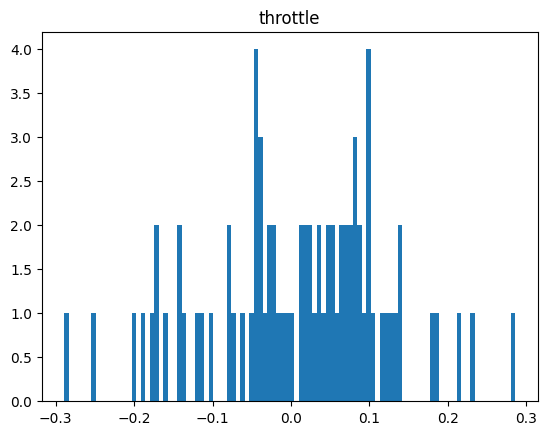

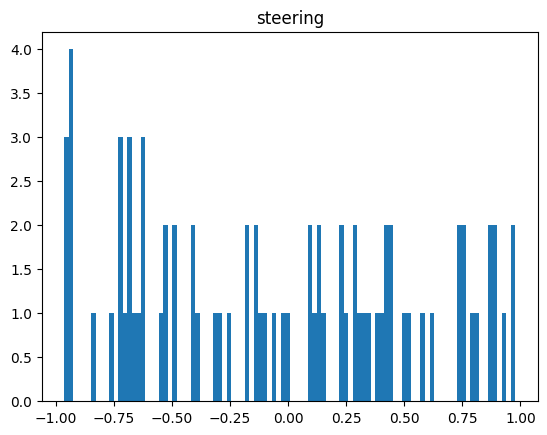

In [44]:
s0batchthrottles = np.array([obs.action.throttle for obs in s0data])
s0batchsteers = np.array([obs.action.steer for obs in s0data])

plt.hist(s0batchthrottles, bins=100)
plt.title('throttle')
plt.show()
plt.hist(s0batchsteers, bins=100)
plt.title('steering')
plt.show()